<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Project: Whether a loan is paid off</font></h1>
<h2 align="center"><font size="5">Deadline: 2020-11-29 18:00:00</font></h2>
<h3 align="center"><font size="5"> Total marks: 6.0</font></h3>

### Your information:
- Fullname: Trần Hoàng Bách

- Date of birth: 01/10/1993

- Email: bach.tranhoang@gmail.com

- Mobile phone: 0985878108

## Import liabraries

In [53]:
# General tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb
%matplotlib inline
import time
import itertools

# Pre-processing tools
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn import over_sampling, under_sampling, combine

# Metrics for testing result
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, plot_confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest, SelectPercentile, f_classif, f_regression, f_oneway
from imblearn.pipeline import Pipeline
from scipy import interp

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

## About dateset
This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

## Load and check data

In [2]:
df = pd.read_csv('loan_train.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

loan_status  Principal  terms effective_date   due_date  age  \
0     PAIDOFF       1000     30       9/8/2016  10/7/2016   45   
1     PAIDOFF       1000     30       9/8/2016  10/7/2016   33   
2     PAIDOFF       1000     15       9/8/2016  9/22/2016   27   
3     PAIDOFF       1000     30       9/9/2016  10/8/2016   28   
4     PAIDOFF       1000     30       9/9/2016  10/8/2016   29   

              education  Gender  
0  High School or Below    male  
1              Bechalor  female  
2               college    male  
3               college  female  
4               college    male

In [3]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['due_date'] = pd.to_datetime(df['due_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     346 non-null    object        
 1   Principal       346 non-null    int64         
 2   terms           346 non-null    int64         
 3   effective_date  346 non-null    datetime64[ns]
 4   due_date        346 non-null    datetime64[ns]
 5   age             346 non-null    int64         
 6   education       346 non-null    object        
 7   Gender          346 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 21.8+ KB


In [4]:
# Create a function to evaluate missing in data, check unique in object (categorical col)
def check_data(df):
    check = []
    for col in df.columns:
        type = df[col].dtypes
        if type == 'object':
            unique_obj = df[col].unique()
        else:
            unique_obj = ''
        total_nan = df[col].isnull().sum()
        percent_nan = total_nan/len(df[col])
        check.append([col, type, total_nan, percent_nan, unique_obj])
    check_df = pd.DataFrame(check, columns=['Col', 'Type', 'Total_NaN', 'Percent', 'Unique'])
    return check_df
    
check_data(df)

Col            Type  Total_NaN  Percent  \
0     loan_status          object          0      0.0   
1       Principal           int64          0      0.0   
2           terms           int64          0      0.0   
3  effective_date  datetime64[ns]          0      0.0   
4        due_date  datetime64[ns]          0      0.0   
5             age           int64          0      0.0   
6       education          object          0      0.0   
7          Gender          object          0      0.0   

                                              Unique  
0                              [PAIDOFF, COLLECTION]  
1                                                     
2                                                     
3                                                     
4                                                     
5                                                     
6  [High School or Below, Bechalor, college, Mast...  
7                                     [male, female]

## Identify Variables, Feature Extraction

In [5]:
# Geting week, dayofweek, day from effective date and due_date
def get_more_variable(df):
    df_new = df.copy()
    df_new['eff_month'] = df_new['effective_date'].dt.month
    df_new['eff_day'] = df_new['effective_date'].dt.day
    df_new['eff_dayofweek'] = df_new['effective_date'].dt.dayofweek
    df_new['eff_weekofmonth'] = (df_new['eff_day'] - 1) // 7 + 1

    df_new['due_month'] = df_new['due_date'].dt.month
    df_new['due_day'] = df_new['due_date'].dt.day
    df_new['due_dayofweek'] = df_new['due_date'].dt.dayofweek
    df_new['due_weekofmonth'] = (df_new['due_day'] - 1) // 7 + 1

    return df_new

df = get_more_variable(df)

cate_visual = ['education', 'Gender', 'eff_day', 'eff_dayofweek', 'eff_weekofmonth', 'due_day', 'due_dayofweek', 'due_weekofmonth', 'eff_month', 'due_month']
num_visual = ['age', 'Principal', 'terms']
target_col = 'loan_status'

order_sort = {'education': ['High School or Below', 'college', 'Bechalor', 'Master or Above']}
order_rename = {'eff_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'due_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

# Set color specific consistant for all charts
d = len(df[target_col].unique())
c_palette = sb.color_palette('colorblind')
colors = [c_palette[i] for i in range(d-1, -1, -1)]

df.head()

loan_status  Principal  terms effective_date   due_date  age  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   33   
2     PAIDOFF       1000     15     2016-09-08 2016-09-22   27   
3     PAIDOFF       1000     30     2016-09-09 2016-10-08   28   
4     PAIDOFF       1000     30     2016-09-09 2016-10-08   29   

              education  Gender  eff_month  eff_day  eff_dayofweek  \
0  High School or Below    male          9        8              3   
1              Bechalor  female          9        8              3   
2               college    male          9        8              3   
3               college  female          9        9              4   
4               college    male          9        9              4   

   eff_weekofmonth  due_month  due_day  due_dayofweek  due_weekofmonth  
0                2         10        7              4                1  
1                2         10        7              4                1  
2                2          9       22              3                4  
3                2         10        8              5                2  
4                2         10        8              5                2

In [6]:
# Prepare df_test along with df_train
df_test = pd.read_csv('loan_test.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
df_test['due_date'] = pd.to_datetime(df_test['due_date'])
df_test = get_more_variable(df_test)

## Univariate Analysis

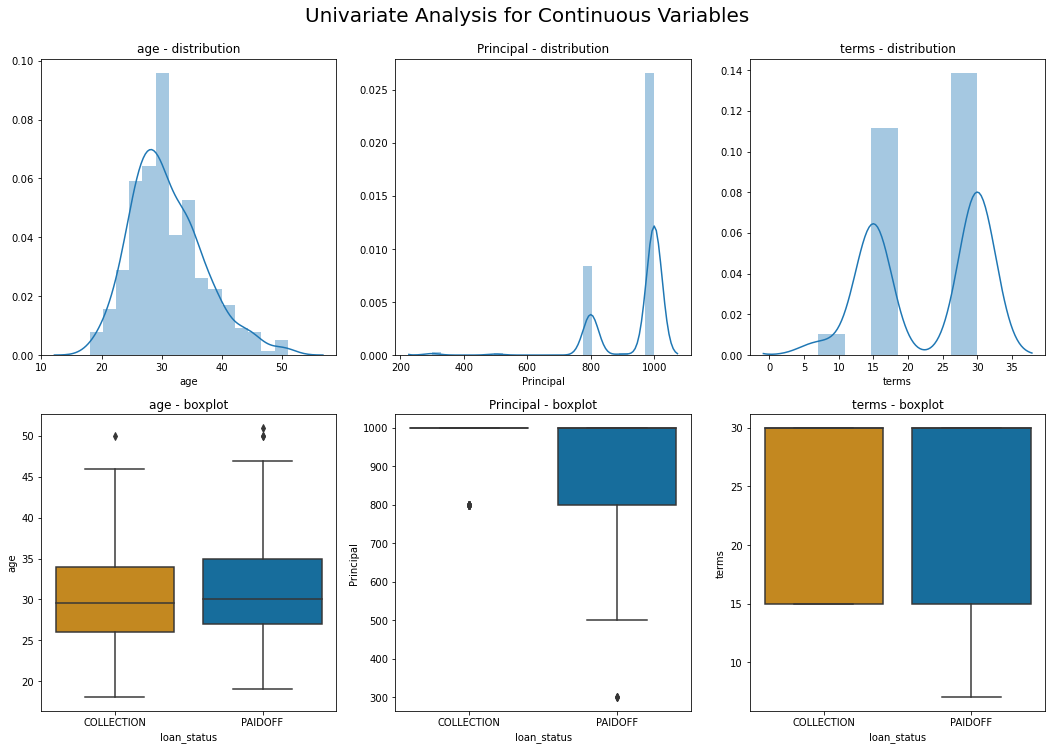

In [7]:
# Write a function display charts for continous variables: displot and boxplot
def plot_univariate_analysis_continuous_variables(df, num_col, target_col, size_height=6, size_width=6):
    # Setup chart
    n = len(num_col)
    d = len(df[target_col].unique())
    c_palette = sb.color_palette('colorblind')
    colors = [c_palette[i] for i in range(d-1, -1, -1)]
    fig, axes = plt.subplots(2, n, figsize=(size_height*n, size_width*2))
    i = 1

    # Draw displot on first row
    for col in num_col:
        plt.subplot(2, n, i)
        sb.distplot(df[col])
        plt.title(col+ ' - distribution')
        i += 1

    # Draw boxplot with hue on target_col on second row
    for col in num_col:
        plt.subplot(2, n, i)
        sb.boxplot(data=df.sort_values(target_col), y=col, x=target_col, palette=colors)
        plt.title(col+ ' - boxplot')
        i += 1
    fig.suptitle('Univariate Analysis for Continuous Variables', y=0.94, size=20)
    plt.show()

plot_univariate_analysis_continuous_variables(df, num_visual, target_col)

### Univariance Analysis on Continuous Variables
#### Age: 
- Have good shape sample, nearly normal distribution

- Have litle 2-3 outliers, but outliers is okie because having people 50 years old is not abnormal

- Not difference between age and loan_status

#### Principal:
- Not like a quantitative variable since only 4 unique values: 300, 500, 800, 1000.

- Seem most COLLECTION are at Principal 1000, and 1 on 800

- Suggest treat Principal like Quanlitative variable because too little unique value and for more analysis with other Categorical Variables

#### Terms:
- Also like Principal, only 3 unique values: 7, 15, 30.

- Not difference in when split by loan_status

- Suggest treat Terms like Quanlitative variable for more analysis with other Categorical Variables

In [8]:
cate_visual = ['Principal', 'terms'] + cate_visual

In [9]:
def plot_category_count_hue_stacked(df, x_col, target_col, order_sort, order_rename, ax=None):
    # Create group-data for plot
    df_plot = df.groupby([x_col, target_col]).size().reset_index().pivot(index=x_col, columns=target_col, values=0).fillna(0)

    # Create order_sort if we want
    try:
        order_sort_x = order_sort[x_col]
    except Exception:
        order_sort_x = np.sort(df[x_col].unique())

    # df_plot.reindex(order_sort_x)
    # df_plot = df_plot.loc[order_sort_x]
    # Main Plot function
    plot = df_plot.reindex(order_sort_x).plot(kind='bar', stacked=True, rot=0, color=colors, ec='k', width=0.8, ax=ax)

    # Create order_rename if we want
    try:
        order_rename_x = order_rename[x_col]
        plot.set_xticklabels(order_rename_x)
    except Exception:
        pass

    # Write function to plot number about data on each bar
    try:
        bar_patches = np.reshape(plot.patches, (2,-1)).T
        for bot, top in bar_patches:
            height_bot = bot.get_height()
            height_top = bot.get_height() + top.get_height()
            plot.text(bot.get_x() + bot.get_width()/2, height_bot*0.2, '%d' % int(bot.get_height()), ha='center', va='bottom')
            plot.text(top.get_x() + top.get_width()/2, height_top*0.7, '%d' % int(top.get_height()), ha='center', va='bottom')
    except Exception:
        pass
    return plot
## Test plot
# plot_category_count_hue_stacked(df, 'eff_dayofweek', target_col, order_sort, order_rename)

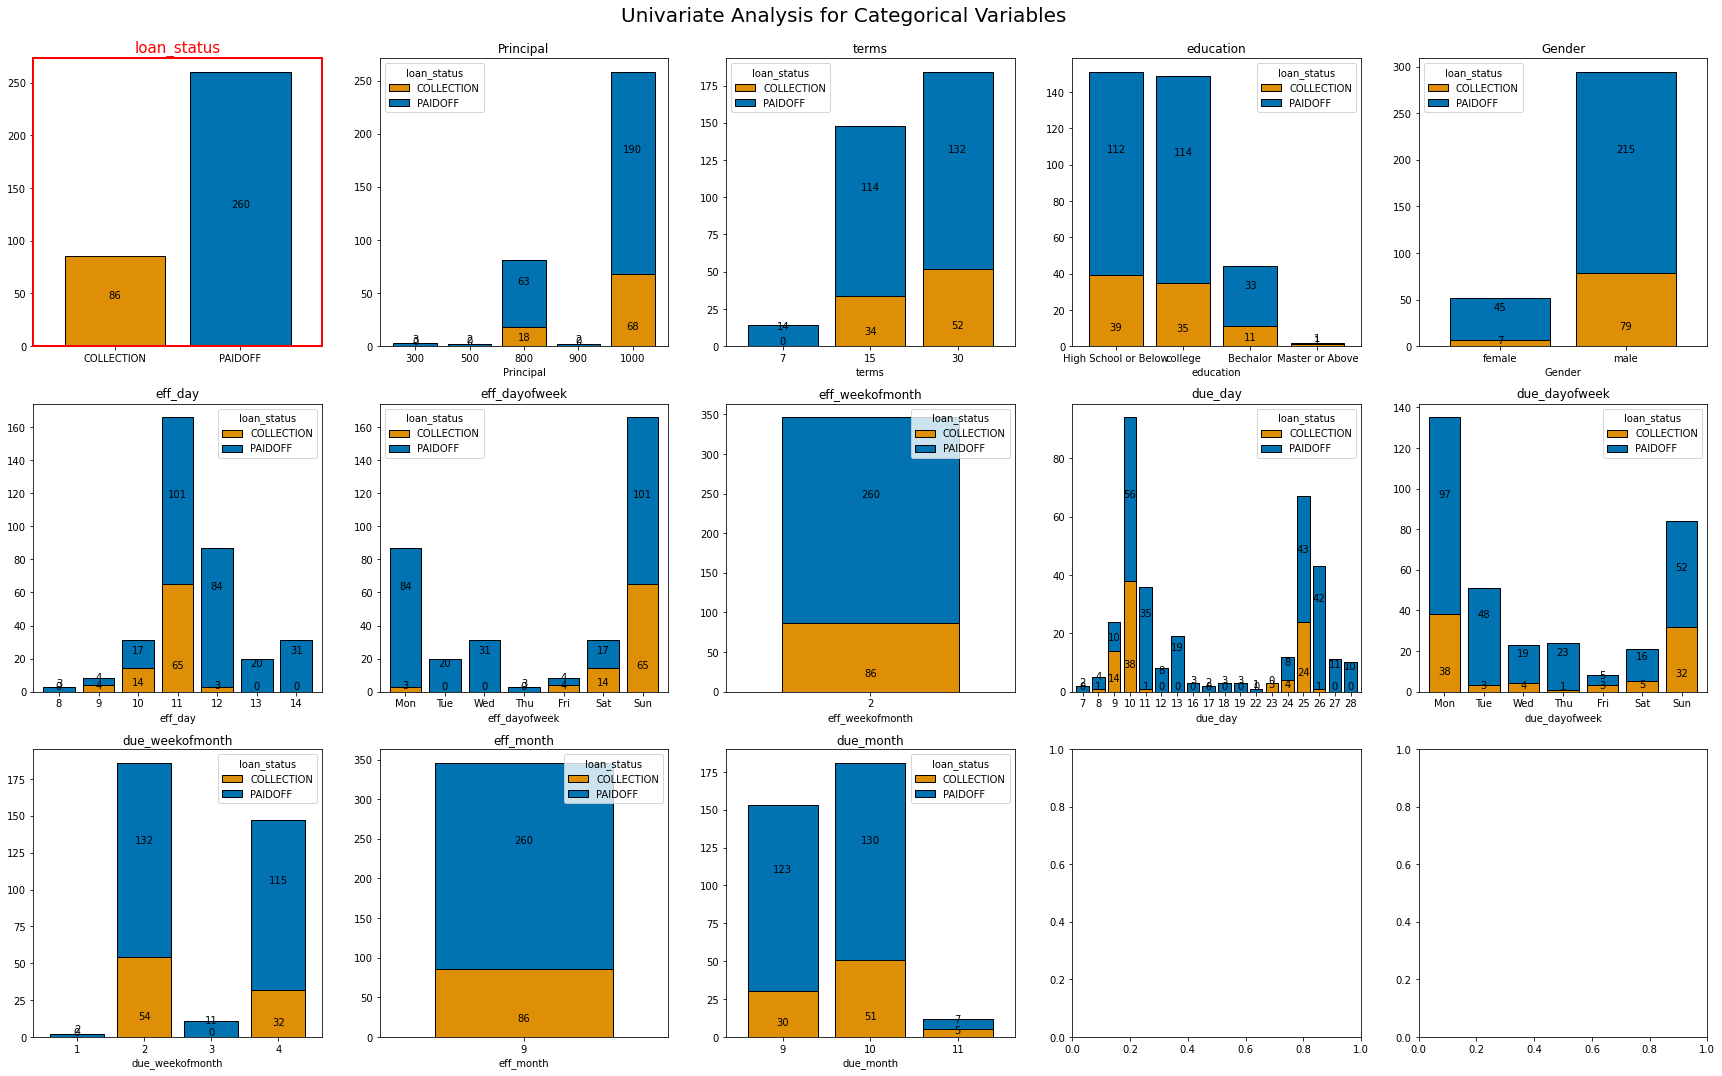

In [10]:
def plot_univariate_analysis_categorical_variables(df, cate_col, target_col, order_sort, order_rename, n_max_col=4, size_height=6, size_width=6):
    # Setup chart
    n_cate = len(cate_col) + 1
    n = min(n_max_col, n_cate)
    m = (n_cate - 1) // n + 1

    d = len(df[target_col].unique())
    c_palette = sb.color_palette('colorblind')
    colors = [c_palette[i] for i in range(d-1, -1, -1)]

    fig, axes = plt.subplots(m, n, figsize=(n*6, m*6))
    axes_total = axes.ravel()

    # Plot target_col
    df_target_plot = df[target_col].value_counts().sort_index()
    plot_target = df_target_plot.plot(kind='bar', color=colors, rot=0, ec='k', width=0.8, ax=axes_total[0])
    plot_target.set_title(target_col, size=15, color='r')
    for bar in plot_target.patches:
        plot_target.text(bar.get_x() + bar.get_width()/2, (bar.get_height())*0.5, '%d' % int(bar.get_height()), ha='center', va='bottom')
    for spine in axes_total[0].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)

    # Main Plot function use for-loops
    for x_col, ax in zip(cate_visual, axes_total[1:]):
        plot = plot_category_count_hue_stacked(df, x_col, target_col, order_sort, order_rename, ax)
        plot.set_title(x_col)
    plt.suptitle('Univariate Analysis for Categorical Variables', y=0.92, size=20)
    plt.show()

order_sort = {'education': ['High School or Below', 'college', 'Bechalor', 'Master or Above']}
order_rename = {'eff_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'due_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

plot_univariate_analysis_categorical_variables(df, cate_visual, target_col, order_sort, order_rename, n_max_col=5)

### Univariance Analysis on Categorical Variables
#### Loan_status (target_classification):
- Imbalance in category, much PAIDOFF than COLLECTION.

- Because of business in banking need to classify COLLECTION right than PAIDOFF, so our model need to have HIGH recall and precision score on COLLECTION

- When convert to dummies, let COLLECTION = 1, PAIDOFF = 0

- Consider to Rebalance dataset by resampling methods before running model

#### Principal:
- Princial 300, 500, 900 have too litte sample, suggest make dummies for Principal only: 800, 10000 like a option

#### terms:
- No Collection on 7 days, make dummies for: 15 days, 30 days

#### education:
- Only 2 count for Master or Above, remain 3 category have diffence in Loan_status, make dummies for: High School or Below, college, Bacalor

#### Gender:
- gender seem be imbalance like Loan_status, have significant difference between loan_status for gender

#### About effective_date, due_day:
- eff_day: have none or very little COLLECTION in day 8, 12, 13, 14, 8 -> make dummies for eff_day_first_third = 1 (9, 10, 11), remaining = 0

- eff_dayofweek: have none or very little COLLECTION in not_weekend (Mon-Thu) -> make dummies for eff_weekend = 1 (4-6), remaining = 0

- due_day: seem most COLLECTION in time first_third (8, 9, 10) and second_third (23, 24, 25) -> make dummies for due_day_first_third (8, 9, 10), due_day_second_third (23, 24, 25), remaining = 0

- due_dayofweek: have none or very little COLLECTION in middle if week (Tue-Thu) -> make dummies for due_middle_week = 1 (1-3), remaining = 0

- due_weekofmonth: have none COLLECTION in month 1,3 -> make dummies for due_weekofmonth_2_4 = 1, remaining = 0

- due_month: make dummies month 9, 10

- eff_weekofmonth and eff_month will be remove because only 1 month or week, not have object to compare

## Bi-variate Analysis

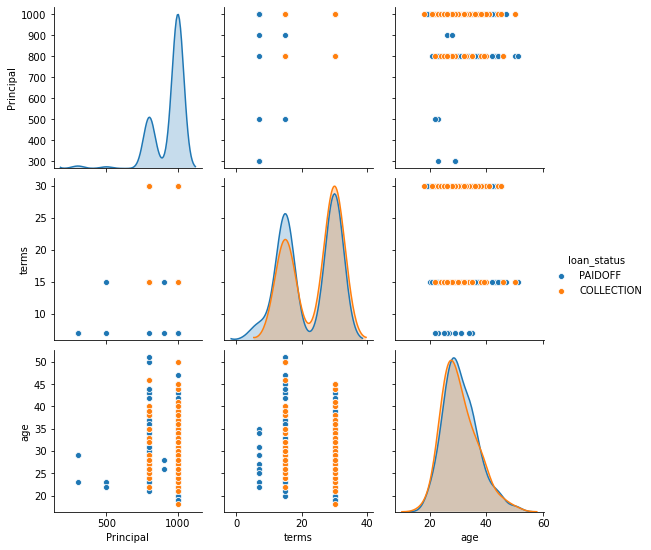

In [11]:
# Plot pair-plot for bi-variate
sb.pairplot(df[['Principal', 'terms', 'age', 'loan_status']], hue='loan_status');

#### When set Principal and terms to Continuous variables, seem not work because too few unique values. Only age work well

In [12]:
# Create a function to draw bi-variate categorical - categorical analysis
def plot_bivariate_analysis_categorical_variables(df, categorical_cols, y_col, target_col, order_sort, order_rename, size_height=6, size_width=6):
    # Remove y_col in cate_cols (if it have)
    cate_cols = categorical_cols.copy()
    try:
        cate_cols.remove(y_col)
    except Exception:
        pass

    # Setup
    y_unique = df[y_col].unique().tolist()
    n = len(y_unique)
    m = len(cate_cols)

    fig, axes = plt.subplots(m,n, figsize=(n*size_width, m*size_height))
    ax = axes.flatten()

    # Main loops plot function
    i = 0
    for x_col in cate_cols:
        # Find y_share for seting y_lim
        y_share_max = df.groupby([x_col, y_col]).size().reset_index()[0].max()*1.1
        for unique in y_unique:
            df_by_y = df[df[y_col]==unique]
            plot = plot_category_count_hue_stacked(df_by_y, x_col, target_col, order_sort, order_rename, ax=ax[i])
            plot.set_ylim([0, y_share_max])
            plot.set_title(x_col + ' - ' + y_col + ' = ' + str(unique))
            i += 1
    plt.suptitle('Bi-variate Analysis Categorical - Categorical, split by '+y_col, size=20, y=0.93)
    plt.show()

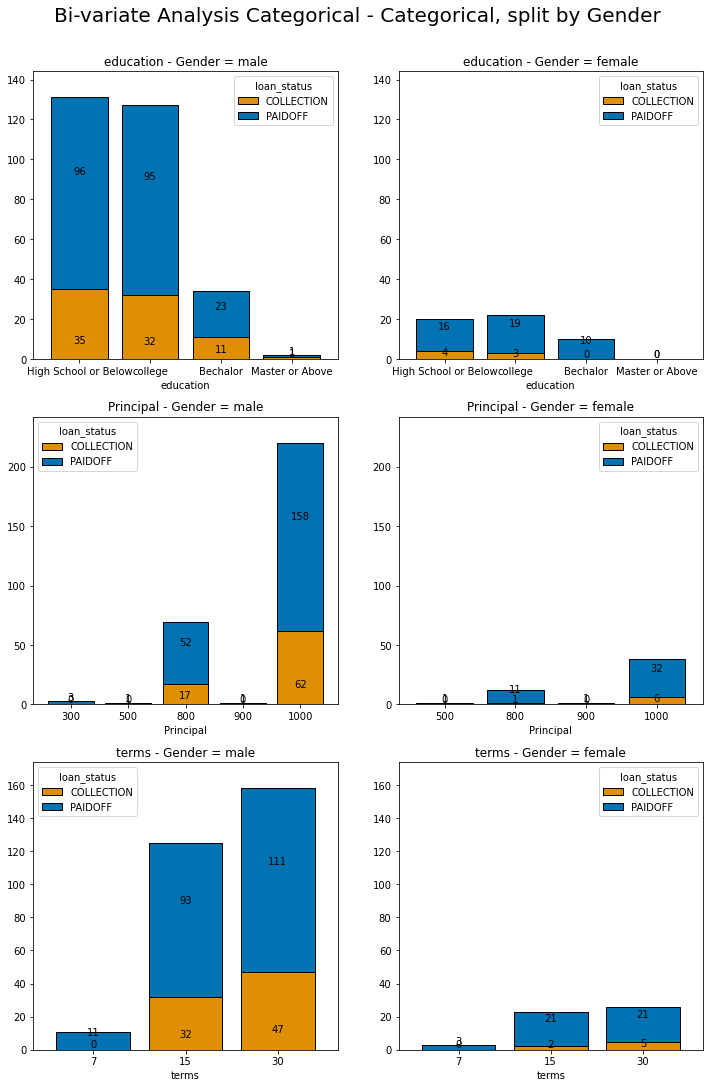

In [13]:
cate_bivariate_cols = ['education', 'Principal', 'terms', 'Gender']
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'Gender', target_col, order_sort, order_rename)

### Bi-variate Analysis split by Gender: 
- It seem female PAIDOFF loan in high probability than male

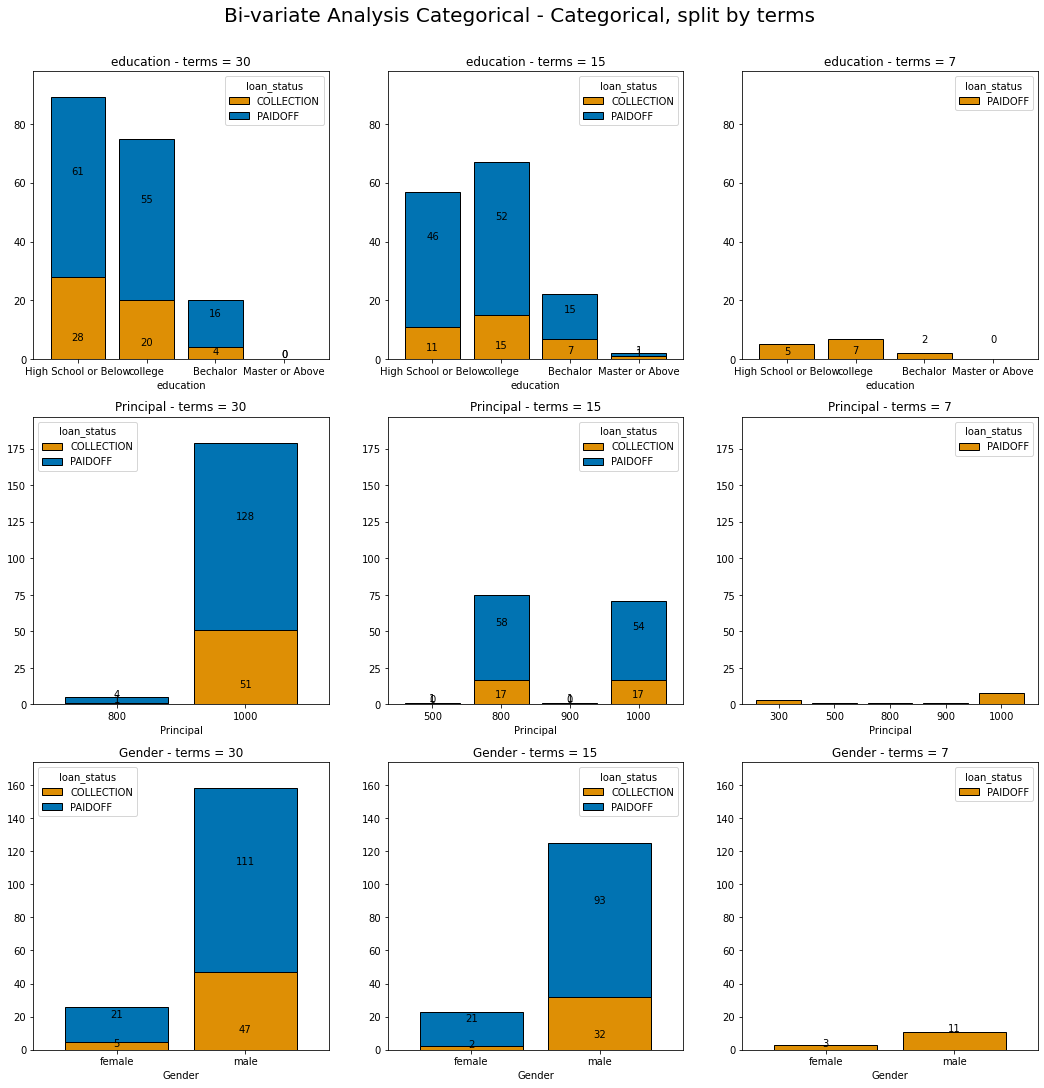

In [14]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'terms', target_col, order_sort, order_rename)

### Bi-variate Analysis split by terms: 
- terms 7 days have fully PAIDOFF

- ratio COLLECTION : PAIDOFF no clear show in terms 30, 15 due to imbalance dataset

- Create dummy for only terms 15, 30 is enough. For example: (1,0) is term-15; (0,1) is term-30; (0,0) is term-7

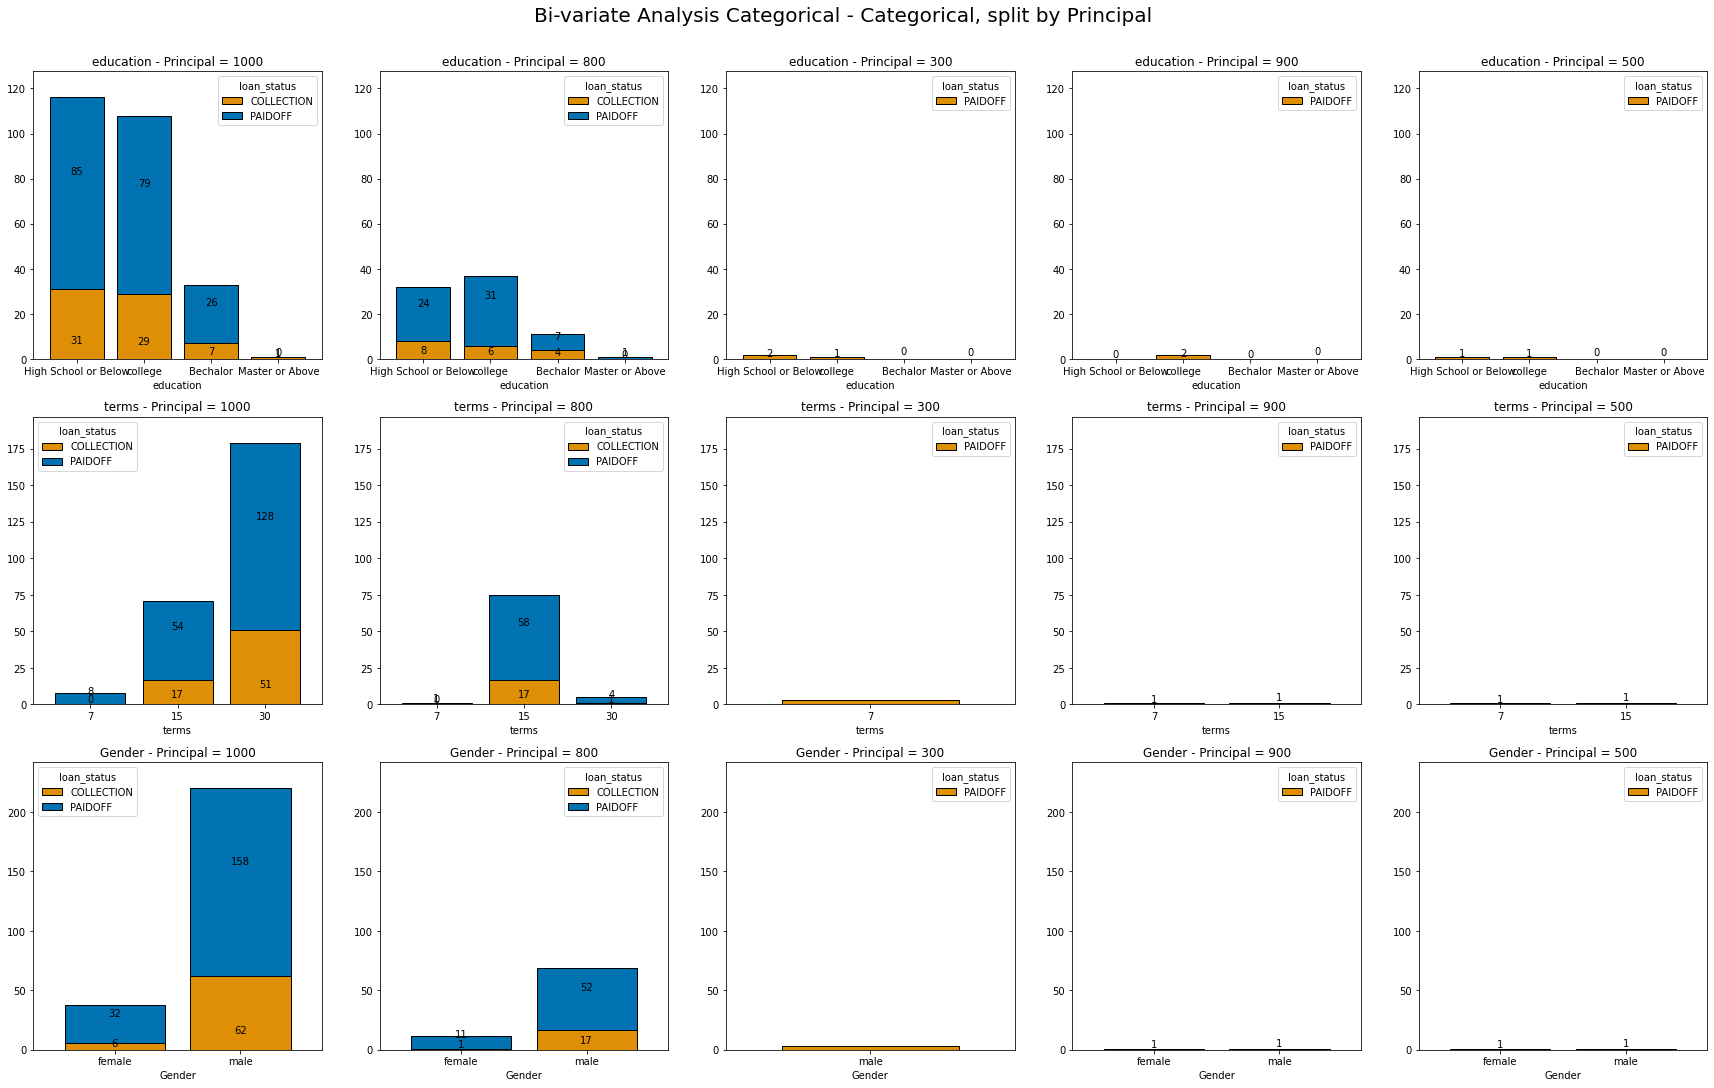

In [15]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'Principal', target_col, order_sort, order_rename)

### Bi-variate Analysis split by Principal:
- Principal 300, 900, 500 payoff all

- Create 2 dummies Principal_800, Principal_1000 is enough

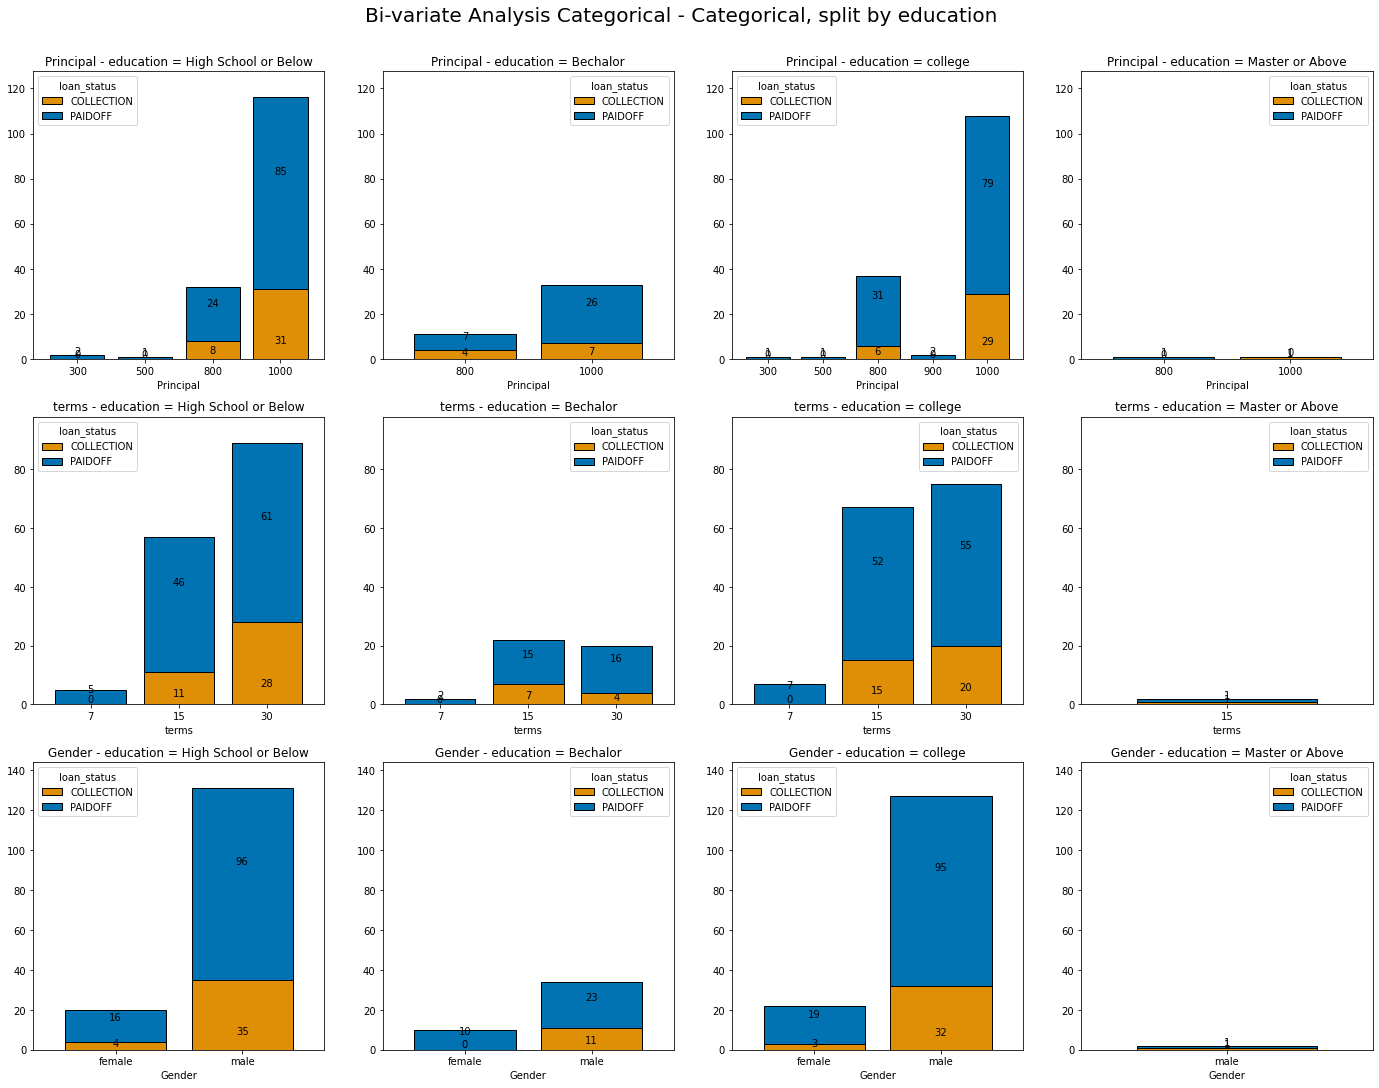

In [16]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'education', target_col, order_sort, order_rename)

### Bi-variate Analysis split by education:
- Very few sample for Master or above education

- Create 3 dummies is enough

### Use statistics for Feature Selection

eff_dayofweek       eff_day       due_day  due_month  due_dayofweek  \
chi_2     5.178080e-25  6.646461e-05  6.936183e-08   0.104471       0.000704   
f_stats   2.561082e-15  3.047349e-11  5.206730e-03   0.024983       0.037210   

           Gender  due_weekofmonth  education  
chi_2    0.423973         0.304207   0.732096  
f_stats  0.039271         0.153976   0.693996

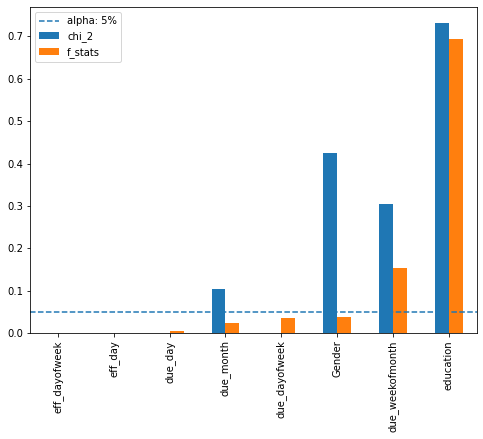

In [17]:
# Write a function to test all categorical variables with chi_2 test and f_stats test:
def statistic_test(df, cate_col, target_col):
    # Copy df
    df_statis = df.copy()

    # Convert all categorical to Ordinal prepare for statistic test
    ordinal_enc = OrdinalEncoder()
    df_statis[cate_col] = ordinal_enc.fit_transform(df_statis[cate_col])

    # Calculate p_values and visualize
    chi_2_p_values = chi2(df_statis[cate_col], df_statis[target_col])[1]
    f_stats_p_values = f_classif(df_statis[cate_col], df_statis[target_col])[1]

    p_values = pd.DataFrame([chi_2_p_values, f_stats_p_values], columns=cate_col, index=['chi_2', 'f_stats'])
    p_values = p_values.sort_values(by='f_stats',axis=1)
    p_values.transpose().plot.bar(figsize=(8,6))
    plt.axhline(y=0.05, ls='--', label='alpha: 5%')
    plt.legend()
    display(p_values)
    return p_values
    
cate_statis_test = ['education', 'Gender', 'eff_day', 'eff_dayofweek', 'due_day', 'due_dayofweek', 'due_weekofmonth', 'due_month']
p_values = statistic_test(df, cate_statis_test, target_col)
statis = p_values.transpose()

In [18]:
features_selected_f_stats_draft = statis[statis['f_stats']<0.05].index.tolist()
features_selected_chi_2_draft = statis[statis['chi_2']<0.05].index.tolist()
print('Features selected by f_stats: ', features_selected_f_stats_draft)
print('')
print('Features selected by chi_2: ', features_selected_chi_2_draft)

Features selected by f_stats:  ['eff_dayofweek', 'eff_day', 'due_day', 'due_month', 'due_dayofweek', 'Gender']

Features selected by chi_2:  ['eff_dayofweek', 'eff_day', 'due_day', 'due_dayofweek']


### Statistic Review:
- By alpha 5%, "due_weekofmonth" and "education" do not have significant impact to predict "loan_status"

- Maybe we can extract more features from 2 variables above and then use statistic to review and and pick feature selection

## Try more Feature Extraction by manual base on Visualize analysis then Feature Selection

In [80]:
# Because we choose feature base on what we analysis, so we only need get dummies and choose dummies_name we want, no need to get all feature like One-hot extraction
def feature_extraction(df):
    df_new = df.copy()
    df_new = pd.get_dummies(df_new, columns=['loan_status','Principal', 'terms', 'education', 'Gender'])

    # Choose only what want through analysis
    cate_new = ['loan_status_COLLECTION', 'age', 'Principal_800', 'Principal_1000', 'terms_15', 'terms_30', 
                'education_High School or Below', 'education_college', 'education_Bechalor', 'Gender_male']

    # Some more feature extraction from eff_date and due_date
    df_new = df_new[cate_new]
    df_new['eff_day_first_third'] = df['eff_day'].map(lambda x: 1 if x in [9, 10, 11] else 0)
    df_new['eff_weekend'] = df['eff_dayofweek'].map(lambda x: 1 if x in [4, 5, 6] else 0)
    df_new['due_day_first_third'] = df['due_day'].map(lambda x: 1 if x in [8, 9, 10] else 0)
    df_new['due_day_second_third'] = df['due_day'].map(lambda x: 1 if x in [23, 24, 25] else 0)
    df_new['due_middle_week'] = df['due_dayofweek'].map(lambda x: 1 if x in [1, 2, 3] else 0)
    df_new['due_weekofmonth_2_4'] = df['due_weekofmonth'].map(lambda x: 1 if x in [2, 4] else 0)
    df_new['due_month_9'] = df['due_month'].map(lambda x: 1 if x == 9 else 0)
    df_new['due_month_10'] = df['due_month'].map(lambda x: 1 if x == 10 else 0)

    return df_new

train = feature_extraction(df)
test = feature_extraction(df_test)

# We treat only age be Continuous variable, so only normalize it
std_scaler = StandardScaler()
train['age'] = std_scaler.fit_transform(train[['age']])
test['age'] = std_scaler.transform(test[['age']])

# Train, test data after all feature selection
X_train, y_train = train.drop(columns='loan_status_COLLECTION'), train['loan_status_COLLECTION']
X_test, y_test = test.drop(columns='loan_status_COLLECTION'), test['loan_status_COLLECTION']
data_train = (X_train, y_train, 'data train')
data_test = (X_test, y_test, 'data test')

eff_day_first_third   eff_weekend  due_day_first_third  \
chi_2           2.231572e-07  2.231572e-07         2.879713e-06   
f_stats         1.688246e-17  1.688246e-17         2.551170e-09   

         due_middle_week  due_day_second_third  due_weekofmonth_2_4  \
chi_2           0.000132              0.006662             0.682014   
f_stats         0.000005              0.001828             0.034607   

         Gender_male  due_month_9  terms_30  due_month_10  Principal_1000  \
chi_2       0.423973     0.133114   0.28514      0.301172        0.576910   
f_stats     0.039271     0.044473   0.11896      0.135117        0.269927   

         terms_15  Principal_800  education_college  \
chi_2    0.596167       0.583434           0.699723   
f_stats  0.485036       0.532290           0.610474   

         education_High School or Below  education_Bechalor  
chi_2                          0.782191            0.982304  
f_stats                        0.713643            0.981128

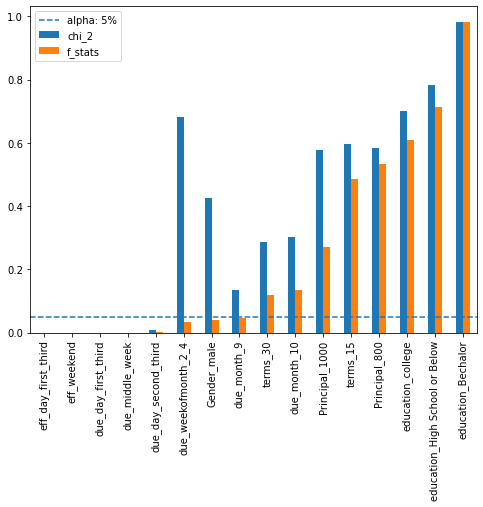

In [81]:
cate_statis_test_2 = train.columns.drop(['loan_status_COLLECTION', 'age'])
target_col_2 = 'loan_status_COLLECTION'
p_values_2 = statistic_test(train, cate_statis_test_2, target_col_2)
statis_2 = p_values_2.transpose()

In [82]:
features_selected_f_stats = statis_2[statis_2['f_stats']<=0.05].index.tolist()
features_selected_chi_2 = statis_2[statis_2['chi_2']<=0.05].index.tolist()
print('Features selected by f_stats: ', features_selected_f_stats)
print('')
print('Features selected by chi_2: ', features_selected_chi_2)

Features selected by f_stats:  ['eff_day_first_third', 'eff_weekend', 'due_day_first_third', 'due_middle_week', 'due_day_second_third', 'due_weekofmonth_2_4', 'Gender_male', 'due_month_9']

Features selected by chi_2:  ['eff_day_first_third', 'eff_weekend', 'due_day_first_third', 'due_middle_week', 'due_day_second_third']


### Review features selected by Statistic after more Extraction:
- In new features selected, all "terms", "princial" and "education" have not enough statistic impact for prediction Loan status

- We keep 2 options on features selected and run Cross Validation to see wether use Statistic Feature selected can make prediction better

## Train model and using Cross Validation method to get result

In [24]:
def process_get_metrics_values(model, X_train, y_train, X_test, y_test):
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall_draw = np.linspace(1, 0, 100)
    # Get FPR, TPR for ROC chart + AUC
    try:
        y_proba = model.fit(X_train, y_train).decision_function(X_test)
    except Exception:
        y_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, drop_intermediate=False)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0
    interp_tpr[-1] = 1

    # Get precision_draw, recall_draw due to changes in thresholds
    preci_draw, recall_draw, thres = precision_recall_curve(y_test, y_proba)
    preci_draw[-1] = 1
    interp_preci = np.interp(mean_recall_draw, recall_draw, preci_draw, period=1)
    interp_preci[-1] = 1
    interp_preci[0] = 0
    no_skill = len(y_test[y_test==1]) / len(y_test)
    avg_preci_score = average_precision_score(y_test, y_proba)

    # Get other metrics: accuracy, balanced_accuracy, precision, recall, f1
    y_pred = model.predict(X_test)

    return {'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'fpr': mean_fpr,
            'tpr': interp_tpr,
            'recall_draw': mean_recall_draw,
            'preci_draw': interp_preci,
            'no_skill': no_skill,
            'avg_preci': avg_preci_score 
            }

In [25]:
# Create a function to get all fpr, tpr for ROC chart and other metrics: accuracy, balanced_accuracy, precision, recall, f1
def result_cv_model(model, data_train, feature_selected=None, rebalance_method=None, cv=5):
    # Get X, y with feature_selected
    X_full, y, name_data = data_train
    # if feature_selected == None:
    try:
        X = X_full[feature_selected]
    except Exception:
        X = X_full

    # Kfold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'fpr', 'tpr', 'recall_draw', 'preci_draw', 'no_skill', 'avg_preci']
    df_metrics = pd.DataFrame(columns=metrics)

    for train, test in kfold.split(X, y):
        if rebalance_method == None:
            X_train, y_train = X.iloc[train], y.iloc[train]
        else:
            X_train, y_train = rebalance_method[0].fit_resample(X.iloc[train], y.iloc[train])
        X_test, y_test = X.iloc[test], y.iloc[test]
        df_metrics = df_metrics.append(process_get_metrics_values(model, X_train, y_train, X_test, y_test), ignore_index=True)

    return dict(np.mean(df_metrics, axis=0))

In [26]:
# Create a function to plot ROC with result getting from cross validation
def plot_cv_roc(result, name_model):
    mean_fpr = result['fpr']
    mean_tpr = result['tpr']
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, lw=(mean_auc-0.5)*5, label=name_model+', auc = {:.2f}'.format(mean_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('ROC chart')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

# Create a function to plot Precision-Recall curve with result getting from cross validation
def plot_cv_precision_recall(result, name_model):
    mean_recall = result['recall_draw']
    mean_precision = result['preci_draw']
    mean_precision[0] = mean_precision[1]
    no_skill = result['no_skill']
    avg_preci = result['avg_preci']
    plt.step(mean_recall, mean_precision, where='post', lw=(avg_preci-0.2)*5, label=name_model+', avg = {:.2f}'.format(avg_preci))
    plt.plot([0, 1], [no_skill, no_skill], 'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('Precision-Recall chart')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

In [28]:
random = 0
models_test = [
                (LogisticRegression(random_state=random), 'Logistic Regression'),
                # (LinearDiscriminantAnalysis(), 'LDA'),
                # (QuadraticDiscriminantAnalysis(), 'QDA'),
                (RandomForestClassifier(random_state=random), 'Random Forest'),
                # (GradientBoostingClassifier(random_state=random), 'Boosting'),
                (SVC(kernel='linear'), 'SVM linear'),
                # (SVC(kernel='poly', degree=2), 'SVM poly-2'),
                # (SVC(kernel='poly', degree=3), 'SVM poly-3'),
                (SVC(kernel='rbf'), 'SVM radial'),
                (KNeighborsClassifier(), 'KNN')
                # (RandomForestClassifier(random_state=random), 'Balanced Random Forest'),
                # (RUSBoostClassifier(random_state=random), 'Balanced Boosting')
            ]

### We can choose many model as we want to evaluate on Train data set, just un-comment and run

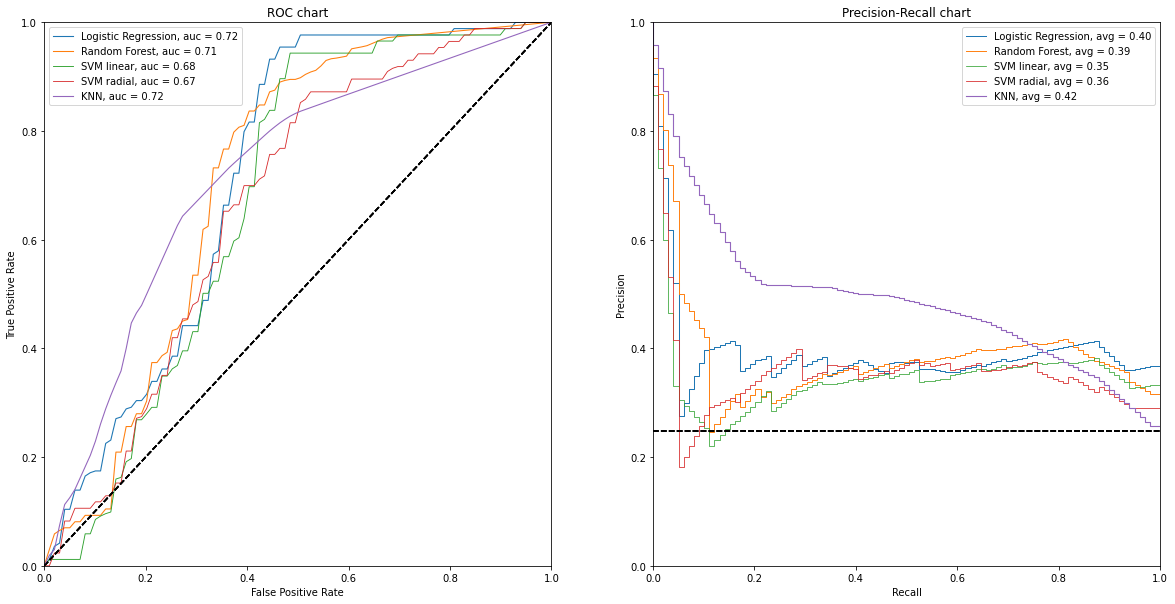

accuracy  balanced_accuracy  precision    recall  \
KNN                  0.731429           0.588172   0.461688  0.303268   
Random Forest        0.690973           0.561249   0.351497  0.303268   
Logistic Regression  0.731222           0.494457   0.240000  0.023529   
SVM linear           0.739876           0.492308   0.000000  0.000000   
SVM radial           0.728489           0.484615   0.000000  0.000000   

                           f1  
KNN                  0.361938  
Random Forest        0.321039  
Logistic Regression  0.040404  
SVM linear           0.000000  
SVM radial           0.000000

In [29]:
# Base case data_train
def plot_roc_chart_multiple_models(models_list, data, feature_selected=None, rebalance_method=None):
    plt.figure(figsize=(20,10))
    score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    for model, name_model in models_list:
        result_model = result_cv_model(model, data, feature_selected=feature_selected, rebalance_method=rebalance_method, cv=5)
        plt.subplot(1,2,1)
        plot_cv_roc(result_model, name_model)
        plt.subplot(1,2,2)
        plot_cv_precision_recall(result_model, name_model)
        # result_model.pop('fpr')
        # result_model.pop('tpr')
        score_table.loc[name_model] = result_model
    if rebalance_method != None:
        plt.title('ROC chart on Resample method: '+ rebalance_method[1])
    plt.show()
    display(score_table.sort_values(by='f1', ascending=False))
plot_roc_chart_multiple_models(models_test, data_train, feature_selected=None)

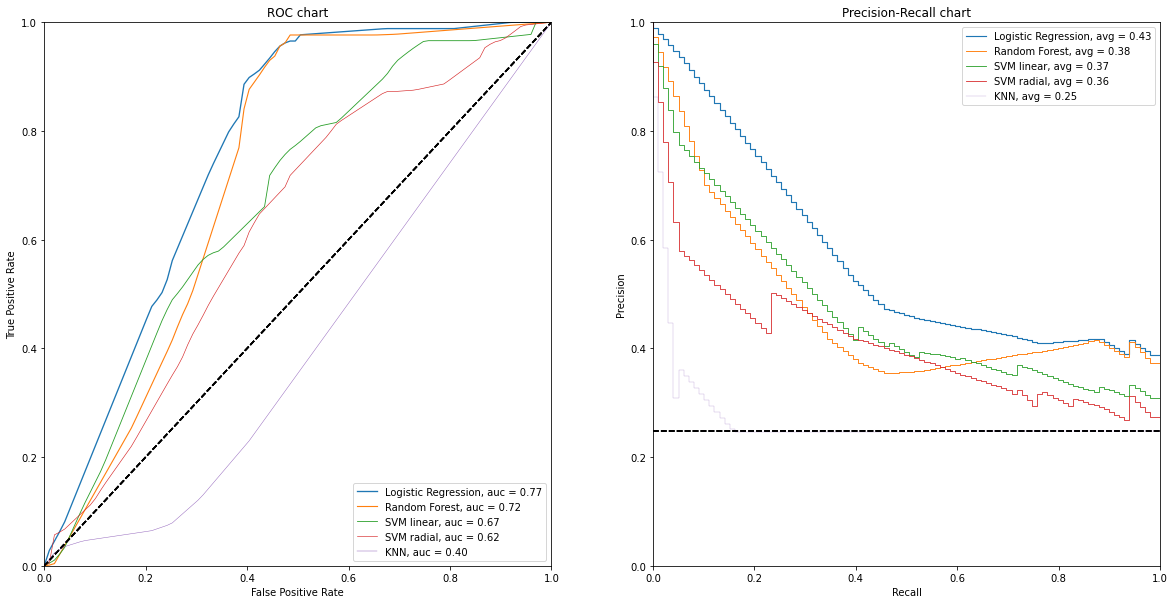

accuracy  balanced_accuracy  precision  recall   f1
Logistic Regression  0.748571           0.498077        0.0     0.0  0.0
Random Forest        0.745673           0.496154        0.0     0.0  0.0
SVM linear           0.742774           0.494231        0.0     0.0  0.0
SVM radial           0.748571           0.498077        0.0     0.0  0.0
KNN                  0.751470           0.500000        0.0     0.0  0.0

In [30]:
# Try on features_selected_f_stats
plot_roc_chart_multiple_models(models_test, data_train, feature_selected=features_selected_f_stats)

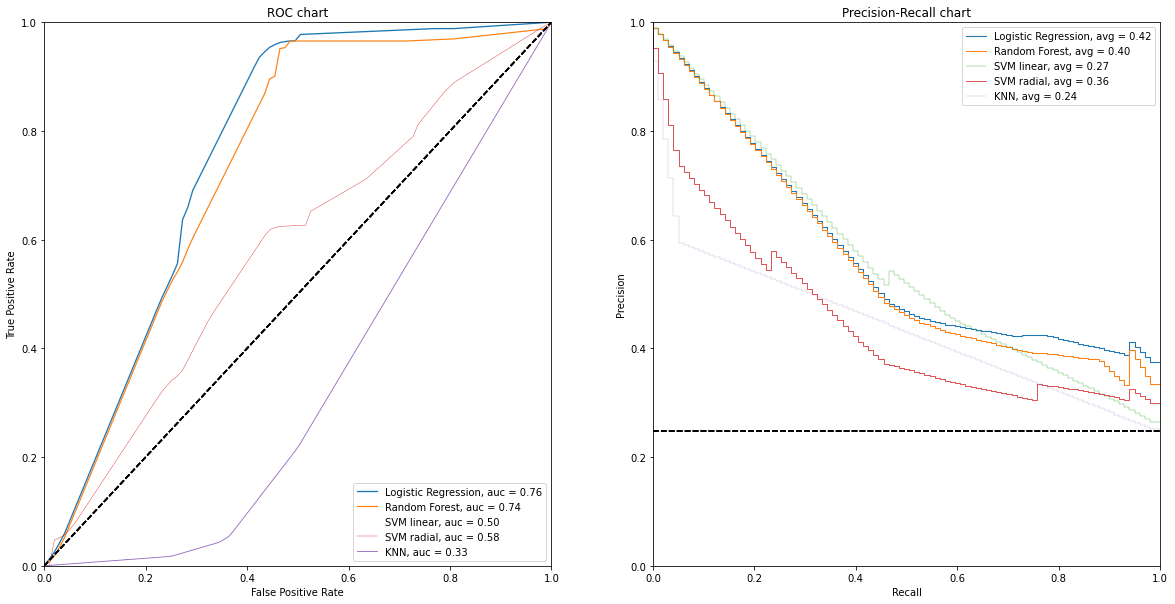

accuracy  balanced_accuracy  precision  recall   f1
Logistic Regression  0.742774           0.494231        0.0     0.0  0.0
Random Forest        0.739876           0.492308        0.0     0.0  0.0
SVM linear           0.742774           0.494231        0.0     0.0  0.0
SVM radial           0.742774           0.494231        0.0     0.0  0.0
KNN                  0.745673           0.496154        0.0     0.0  0.0

In [31]:
# Try on features_selected_chi_2
plot_roc_chart_multiple_models(models_test, data_train, feature_selected=features_selected_chi_2)

### Through the result above:
- Because main purpose to predict right and as much as we can about COLLECTION cases, so we target highest score on f1, which = harmonic_mean_of(precision, recall)

- Balanced_accuracy is another good metric because it = average_of(precision, recall) = 1/2*(precision, recall)

- This can show imbalance data set (75% PAIDOFF) make model seem to predict all is PAIDOFF to get high accuracy but about predict exactly COLLECTION, if FAIL.

- In case full features:
    + KNN (default parameter) have best f1 result is 36.2%, recall 30%, precision 46% for COLLECTION, meaning model predict only right 30% COLLECTION in total COLLECTION cases, and when predict COLLECTION 46% right

    + We also can see through accuracy 73% but balanced_accuracy only 58.8% (higher a little than 50% luck)

    + The basic linear algorithm is Logistic Regression have very bad f1 (4%), recall only 2.3% although accuracy total 73%. 

- In case feature selected:
    + Accuracy overall improved, but balanced_accuracy drop significantly, precision, recall, f1 all zero

    + But the positive is the AUC higher and ROC curve, Precision-Recall curve is more smooth than run with all features

    + precision, recall, f1 all zero but accuracy improved indicate imbalanced data have big impact on this

--> Try to use resample for **Re-balance** data_train before fiting model, we have 2 choices: **Oversampling** or **Undersampling**

## Re-balance data

In [49]:
# Create multiple rebalance method to test
over_sample_Random = [RandomOverSampler(random_state=random), 'Over Sample - Random']
over_sample_SMOTE = [SMOTE('minority', random_state=random), 'Over Sample - SMOTE']
over_sample_SVMSMOTE = [SVMSMOTE(random_state=random), 'Over Sample - SVMSMOTE']
over_sample_SMOTETomek = [SMOTETomek(random_state=random), 'Over Sample - SMOTETomek']
under_sample_Random = [RandomUnderSampler(random_state=random), 'Under Sample - Random']
under_sample_TomekLinks = [TomekLinks(), 'Under Sample - TomekLinks']

rebalance_methods = [over_sample_Random, over_sample_SMOTE, over_sample_SVMSMOTE, over_sample_SMOTETomek, under_sample_Random, under_sample_TomekLinks]

In [50]:
# Data_train + rebalance + features selected
for method_resample in rebalance_methods:
    method, method_name = method_resample
    print('Rebalance method: ' + method_name)
    score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    for model, name_model in models_test:
        result_model = result_cv_model(model, data_train, feature_selected=features_selected_f_stats, rebalance_method=method_resample, cv=5)
        # plot_cv_roc(result_model, name_model)
        result_model.pop('fpr')
        result_model.pop('tpr')
        score_table.loc[name_model] = result_model
    display(score_table.sort_values(by='f1', ascending=False))
    print('')

Rebalance method: Over Sample - Random


accuracy  balanced_accuracy  precision    recall  \
Logistic Regression  0.661946           0.748592   0.417966  0.920261   
SVM radial           0.650352           0.748165   0.411260  0.942484   
SVM linear           0.641656           0.739090   0.403753  0.932026   
Random Forest        0.650352           0.732328   0.407081  0.895425   
KNN                  0.742774           0.498190   0.100000  0.011765   

                           f1  
Logistic Regression  0.574304  
SVM radial           0.572373  
SVM linear           0.562869  
Random Forest        0.559588  
KNN                  0.021053


Rebalance method: Over Sample - SMOTE


accuracy  balanced_accuracy  precision    recall  \
SVM linear           0.647453           0.730405   0.405116  0.895425   
Logistic Regression  0.650352           0.728369   0.406467  0.883660   
SVM radial           0.641698           0.718967   0.398678  0.872549   
Random Forest        0.641698           0.718967   0.398376  0.872549   
KNN                  0.742774           0.494231   0.000000  0.000000   

                           f1  
SVM linear           0.557552  
Logistic Regression  0.556469  
SVM radial           0.546890  
Random Forest        0.546783  
KNN                  0.000000


Rebalance method: Over Sample - SVMSMOTE


accuracy  balanced_accuracy  precision    recall  \
Logistic Regression  0.658799           0.675729   0.393250  0.709150   
SVM linear           0.655901           0.606498   0.326484  0.509150   
SVM radial           0.670393           0.608195   0.333317  0.485621   
Random Forest        0.690683           0.593942   0.353022  0.403268   
KNN                  0.745673           0.496154   0.000000  0.000000   

                           f1  
Logistic Regression  0.500290  
SVM linear           0.389738  
SVM radial           0.386950  
Random Forest        0.366938  
KNN                  0.000000


Rebalance method: Over Sample - SMOTETomek


accuracy  balanced_accuracy  precision    recall  \
SVM linear           0.647453           0.730405   0.405116  0.895425   
Logistic Regression  0.650352           0.728369   0.406467  0.883660   
SVM radial           0.641698           0.718967   0.398678  0.872549   
Random Forest        0.641698           0.718967   0.398376  0.872549   
KNN                  0.742774           0.494231   0.000000  0.000000   

                           f1  
SVM linear           0.557552  
Logistic Regression  0.556469  
SVM radial           0.546890  
Random Forest        0.546783  
KNN                  0.000000


Rebalance method: Under Sample - Random


accuracy  balanced_accuracy  precision    recall  \
Logistic Regression  0.656149           0.759603   0.417477  0.965359   
SVM linear           0.647453           0.753834   0.411052  0.965359   
SVM radial           0.644555           0.751911   0.409001  0.965359   
Random Forest        0.635859           0.730304   0.398175  0.918301   
KNN                  0.739876           0.504186   0.183333  0.035294   

                           f1  
Logistic Regression  0.582834  
SVM linear           0.576560  
SVM radial           0.574555  
Random Forest        0.555306  
KNN                  0.059048


Rebalance method: Under Sample - TomekLinks


accuracy  balanced_accuracy  precision  recall   f1
Logistic Regression  0.748571           0.498077        0.0     0.0  0.0
Random Forest        0.745673           0.496154        0.0     0.0  0.0
SVM linear           0.742774           0.494231        0.0     0.0  0.0
SVM radial           0.748571           0.498077        0.0     0.0  0.0
KNN                  0.751470           0.500000        0.0     0.0  0.0

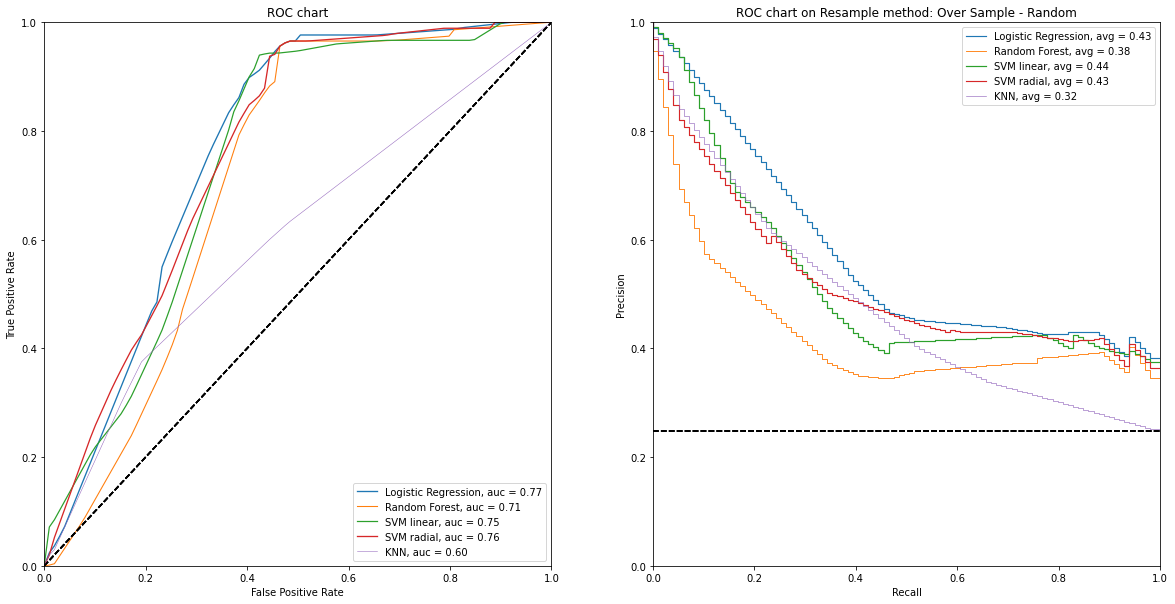

accuracy  balanced_accuracy  precision    recall  \
Logistic Regression  0.661946           0.748592   0.417966  0.920261   
SVM radial           0.650352           0.748165   0.411260  0.942484   
SVM linear           0.641656           0.739090   0.403753  0.932026   
Random Forest        0.650352           0.732328   0.407081  0.895425   
KNN                  0.742774           0.498190   0.100000  0.011765   

                           f1  
Logistic Regression  0.574304  
SVM radial           0.572373  
SVM linear           0.562869  
Random Forest        0.559588  
KNN                  0.021053

In [52]:
# Try on features_selected_f_stats
plot_roc_chart_multiple_models(models_test, data_train, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)

### Result after using rebalance method + features selected:
- We can see f1 sore, balanced_accuracy improved significantly, with Oversample_random, we receive 92% recall and 41.8% precision, balanced_accuracy reach to 74.9%

- Accuracy drop to 66%, it seem trade off between prediction more COLLECTION cases vs average prediction of all IMBALANCE data_set (COLLECTION + PAIDOFF)

- Over sample methods seem work better than Under sample methods because of number of training sample only 350.

- Suggest that use Over Sample - Random

- Suggest that Linear Regression can work well in this case. 

--> Suggest use **Oversample_random** + **features_selected_f_stats** + **Process tuning parameter** for geting better result

## Tunning parameter for models

In [35]:
lr_model = LogisticRegression(random_state=random)
svml_model = SVC(kernel='linear', random_state=random)
svm2_model = SVC(kernel='poly', degree=2, random_state=random)
svmr_model = SVC(kernel='rbf', random_state=random)
qda_model = QuadraticDiscriminantAnalysis()
rdn_forest_model = RandomForestClassifier(random_state=random)
boosting_model = GradientBoostingClassifier(random_state=random)

model_tunning = [(lr_model, 'Linear Regression'), 
                 (svml_model, 'SVM - Linear'),
                 (svm2_model, 'SVM - Poly-2'),
               #   (qda_model, 'QDA'),
                 (rdn_forest_model, 'Random Forest'), 
               #   (boosting_model, 'Boosting'),
                 (svmr_model, 'SVM - Radial')
            ]

In [36]:
param_grid_lr = {'model__penalty': ['l1', 'l2'],
              'model__C': [0.01, 0.1, 1, 5, 10, 15, 20],
              'model__solver': ['liblinear', 'newton-cg'],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_svm_linear = {'model__kernel': ['linear'],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_svm_poly_2 = {'model__kernel': ['poly'],
              'model__degree': [2],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }           
param_grid_svm_radial = {'model__kernel': ['rbf'],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 50],
              'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_qda = {'model__reg_param': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
            }
param_grid_rdn_forest = {'model__n_estimators': [200, 300, 500],
              'model__criterion': ['gini', 'entropy'],
              'model__max_features': [2, 3, 5, 'sqrt', 'log2'],
              'model__class_weight': ['balanced']
            }
param_grid_boosting = {'model__n_estimators': [200, 300, 500],
              'model__learning_rate': [0.001, 0.005, 0.01, 0.1],
              'model__max_depth': [1,2,3]
            }

params = [param_grid_lr, 
          param_grid_svm_linear,
          param_grid_svm_poly_2,
          # param_grid_qda,
          param_grid_rdn_forest,
          # param_grid_boosting, 
          param_grid_svm_radial]

In [51]:
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

def process_tunning_model(model_tunning, params, data_train, feature_selected=None, rebalance_method=None):
    models_final = []
    X_train, y_train, name_data = data_train
    try:
        X_train = X_train[feature_selected]
    except Exception:
        pass
    for model_list, param in zip(model_tunning, params):
        # param = params[i]
        model, model_name = model_list
        if rebalance_method != None:
            pipeline = Pipeline([('rebanlance_method', rebalance_method[0]), ('model', model)])
        else:
            pipeline = Pipeline([('model', model)])
        search = GridSearchCV(pipeline, param, cv=5, scoring='f1')
        search.fit(X_train, y_train)
        best_param = rename_keys(search.best_params_, 'model__')
        model_tunned = model.set_params(**best_param)
        models_final.append((model_tunned, model_name))
    return models_final

models_final = process_tunning_model(model_tunning, params, data_train, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)
models_final

[(LogisticRegression(C=0.01, class_weight='balanced', random_state=0,
                     solver='liblinear'),
  'Linear Regression'),
 (SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=0),
  'SVM - Linear'),
 (SVC(C=0.01, class_weight='balanced', degree=2, kernel='poly', random_state=0),
  'SVM - Poly-2'),
 (RandomForestClassifier(class_weight='balanced', max_features=2,
                         n_estimators=200, random_state=0),
  'Random Forest'),
 (SVC(C=0.1, class_weight='balanced', random_state=0), 'SVM - Radial')]

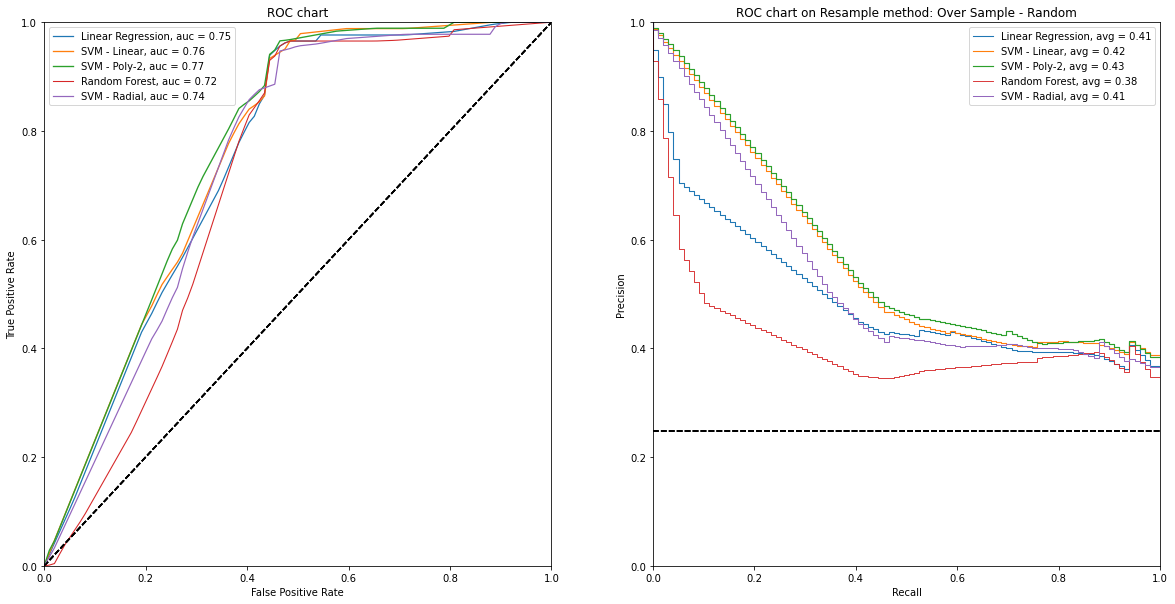

accuracy  balanced_accuracy  precision    recall        f1
SVM - Radial       0.656149           0.752011   0.415491  0.942484  0.576508
SVM - Poly-2       0.653251           0.750088   0.413333  0.942484  0.574430
Linear Regression  0.638799           0.748064   0.405122  0.965359  0.570658
SVM - Linear       0.638799           0.748064   0.405122  0.965359  0.570658
Random Forest      0.647453           0.730405   0.404786  0.895425  0.557380

In [48]:
plot_roc_chart_multiple_models(models_final, data_train, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)

## After tunning models: 
- SVM_Linear with tunned parameter work best with f1 score 60%, very good recall 92.8% indicate it predict almost all COLLECTION cases.

- Compare to basic model without tunning parameter, all final model improve significant on f1, recall, precision and balanced_accuracy.

- In this data set, Linear Regression seem work good.

## Run model and make prediction on data test

In [39]:
def run_test_model(model, data_train, data_test, feature_selected=None, rebalance_method=None):
    # Get X_train, X_test, y_train, y_test with feature_selected
    X_train_full, y_train, data_train_name = data_train
    X_test_full, y_test, data_test_name = data_test

    try:
        X_train = X_train_full[feature_selected]
        X_test = X_test_full[feature_selected]
    except Exception:
        X_train = X_train_full
        X_test = X_test_full

    # Fit model with rebalance_method on training set or not
    if rebalance_method != None:
        X_train, y_train = rebalance_method[0].fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {'accuracy': accuracy, 'balanced_accuracy': balanced_accuracy, 
            'precision': precision, 'recall': recall, 'f1': f1}

def result_test_multiple_models(models_final, data_train, data_test, feature_selected=None, rebalance_method=None):
    test_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    for model, name_model in models_final:
        result_model = run_test_model(model, data_train, data_test, feature_selected=feature_selected, rebalance_method=rebalance_method)
        test_table.loc[name_model] = result_model
    display(test_table.sort_values(by='f1', ascending=False)) 

In [71]:
result_test_multiple_models(models_final, data_train, data_test, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)

accuracy  balanced_accuracy  precision    recall        f1
SVM - Linear       0.685185           0.764286   0.448276  0.928571  0.604651
SVM - Poly-2       0.685185           0.764286   0.448276  0.928571  0.604651
SVM - Radial       0.685185           0.764286   0.448276  0.928571  0.604651
Linear Regression  0.592593           0.701786   0.382353  0.928571  0.541667
Random Forest      0.629630           0.680357   0.392857  0.785714  0.523810

In [74]:
def transform_data_final(data, feature_selected=None, rebalance_method=None):
    X_full, y, data_name = data
    try:
        X_final = X_full[feature_selected]
    except Exception:
        X_final = X_full
    # Fit model with rebalance_method on training set or not
    if rebalance_method != None:
        X_final, y = rebalance_method[0].fit_resample(X_final, y)
    return X_final, y

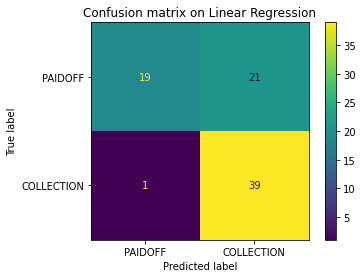

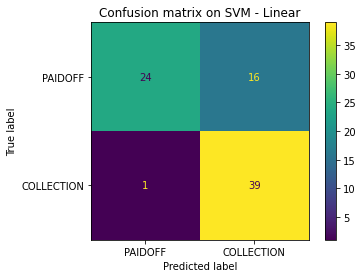

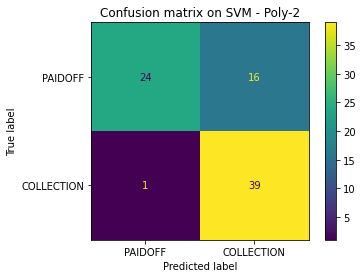

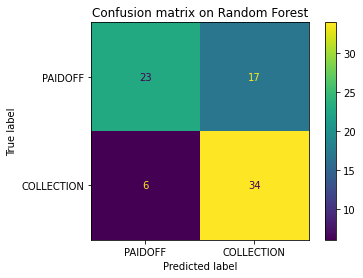

In [77]:
# Plot Confusion matrix on test data
for model, model_name in models_final[:4]:
    X_train_final, y_train = transform_data_final(data_train, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)
    X_test_final, y_test = transform_data_final(data_test, feature_selected=features_selected_f_stats, rebalance_method=over_sample_Random)
    model.fit(X_train_final, y_train)
    plot_confusion_matrix(model, X_test_final, y_test, display_labels=['PAIDOFF', 'COLLECTION'])
    plt.title('Confusion matrix on '+ model_name)

## Final Result on test set
- Main purpose of model is Predict COLLECTION in loan_status, help bank to early define Who will have high probability NOT PAYOFF the Loan in future

- Recall 92%, not different with our training recall. In Logistic Regression, it predict right 39/40 cases of COLLECTION, and keep precision at 40%

- **Conclusion:** Logistic Regression on data after cleaning, feature extraction, feature selection, standard scaler, fit and tunning model have very good result

### Try using PCA for reduce to 2-dimention of data and build model for visualization

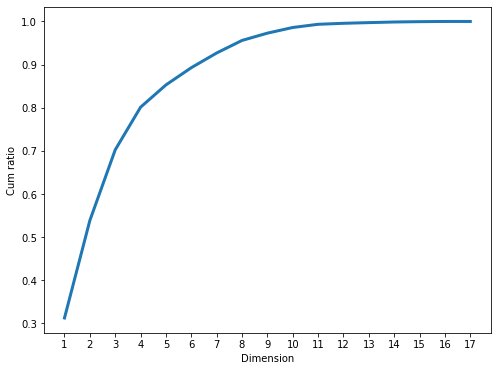

In [78]:
# Create PCA and transform to all principal components
pca_n = PCA()
P = pd.DataFrame(pca_n.fit_transform(X_train))

# Create a table to see how explained variance ratio change due to incease number of components
dimension_variance_explained = pd.DataFrame({'Dimension': np.arange(1,pca_n.n_components_ + 1),'Cum ratio': np.cumsum(pca_n.explained_variance_ratio_)})

# Draw variance explained by PCA
plt.figure(figsize=(8,6))
sb.lineplot(data=dimension_variance_explained, x='Dimension', y='Cum ratio', linewidth=3)
plt.xticks(dimension_variance_explained['Dimension'])
plt.show()

### We can pick at 6,7 Dimension and run Prediction again but here we only want to Visualize all feature reduce to 2 dimension

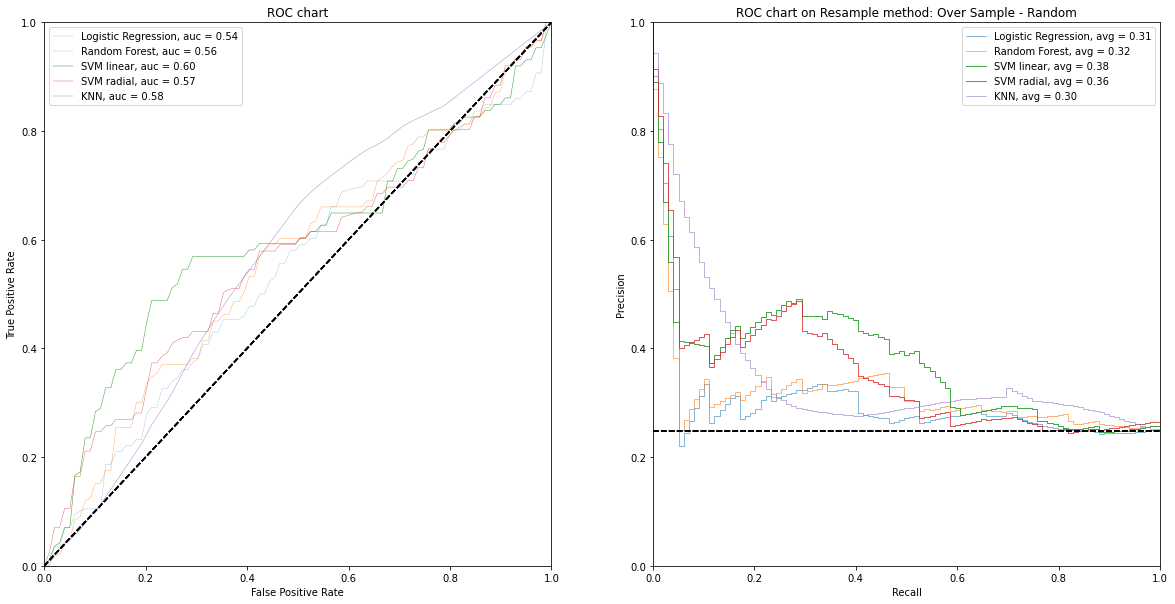

accuracy  balanced_accuracy  precision    recall  \
KNN                  0.583561           0.574912   0.312483  0.557516   
SVM radial           0.615487           0.579902   0.324513  0.509804   
SVM linear           0.514451           0.551860   0.282489  0.626797   
Logistic Regression  0.511470           0.534100   0.270555  0.579739   
Random Forest        0.670352           0.555053   0.333617  0.325490   

                           f1  
KNN                  0.398193  
SVM radial           0.395951  
SVM linear           0.389019  
Logistic Regression  0.368713  
Random Forest        0.325730

In [83]:
n = 2
pca = PCA(n)
pca.fit(X_train)
X_train_pca = pd.DataFrame(pca.transform(X_train), columns=['PC_'+str(i) for i in range(1,n+1)])
X_test_pca = pd.DataFrame(pca.transform(X_test), columns=['PC_'+str(i) for i in range(1,n+1)])
data_train_pca = (X_train_pca, y_train, '2-PCA data train')
data_test_pca = (X_test_pca, y_test, '2-PC data test')
plot_roc_chart_multiple_models(models_test, data_train_pca, rebalance_method=over_sample_Random)

In [84]:
models_final_pca = process_tunning_model(model_tunning, params, data_train_pca, rebalance_method=over_sample_Random)
models_final_pca

[(LogisticRegression(C=0.1, class_weight='balanced', random_state=0,
                     solver='liblinear'),
  'Linear Regression'),
 (SVC(C=0.01, class_weight='balanced', kernel='linear', random_state=0),
  'SVM - Linear'),
 (SVC(C=1, class_weight='balanced', degree=2, kernel='poly', random_state=0),
  'SVM - Poly-2'),
 (RandomForestClassifier(class_weight='balanced', max_features=2,
                         n_estimators=300, random_state=0),
  'Random Forest'),
 (SVC(C=10, class_weight='balanced', random_state=0), 'SVM - Radial')]

In [85]:
result_test_multiple_models(models_final_pca, data_train_pca, data_test_pca, rebalance_method=over_sample_Random)

accuracy  balanced_accuracy  precision    recall        f1
SVM - Poly-2       0.814815           0.782143   0.625000  0.714286  0.666667
SVM - Radial       0.759259           0.767857   0.523810  0.785714  0.628571
Linear Regression  0.518519           0.535714   0.285714  0.571429  0.380952
SVM - Linear       0.481481           0.510714   0.266667  0.571429  0.363636
Random Forest      0.722222           0.580357   0.444444  0.285714  0.347826

### Visualize result of Prediction on pca-2 data

In [86]:
# Write function to visualize on 2 dimentional data
def plot_2_demintions_result(model, data_train, data_test, feature_selected=None, rebalance_method=None):
    # Get X_train, X_test, y_train, y_test with feature_selected
    X_train_full, y_train, data_train_name = data_train
    X_test_full, y_test, data_test_name = data_test
    if feature_selected == None:
        X_train = X_train_full
        X_test = X_test_full
    else:
        X_train = X_train_full[feature_selected]
        X_test = X_test_full[feature_selected]
        
    # Fit model with rebalance_method on training set or not
    if rebalance_method != None:
        X_train, y_train = rebalance_method[0].fit_resample(X_train, y_train)

    model.fit(X_train, y_train)

    # Plot Scatter and Create Grid X, Y, Z
    sb.scatterplot(data=X_test, x=X_test.columns[0], y=X_test.columns[1], hue=y_test, s=80)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    X = np.linspace(x_min, x_max, 120)
    Y = np.linspace(y_min, y_max, 120)
    X, Y = np.meshgrid(X, Y)
    Z = model.predict(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)

    # LDA area and boundary
    plt.contourf(X, Y, Z, alpha=0.1)
    plt.contour(X, Y, Z, linewidth=0.05, color='k')
    y_pred = model.predict(X_test)

    plt.plot([], [], color='white', label='Test accuracy: %.3f' %np.mean(y_pred==y_test))
    plt.legend()
    # plt.text(0.8, 8, 'Test accuracy: %.3f' %np.mean(y_pred==y_test))

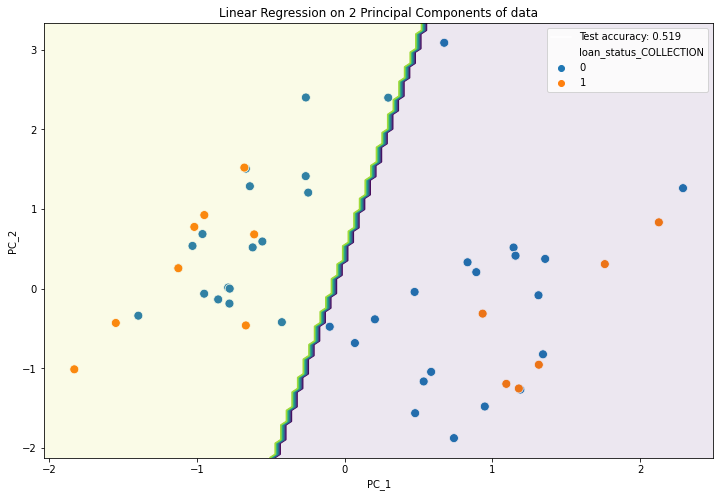

In [90]:
# for model, name_model in models_final:
plt.figure(figsize=(12,8))
plot_2_demintions_result(models_final_pca[0][0], data_train_pca, data_test_pca, feature_selected=None, rebalance_method=over_sample_Random)
plt.title('Linear Regression on 2 Principal Components of data')
plt.show()

## Finished! 
### In this course I learnt alot, combination between Data pre-processing and Modeling
### This is a small data so I can try many methods and time for tunning models not too much.
### In reality, if data is bigger, we only can try few methods we think it best or try Deep learning for geting more better result